In [1]:
import torch

A = torch.tensor([ 512, 768, 1024, 1280, 1600])
B = (A/768) ** -0.5
# Python
C = {int(a): float(b) for a, b in zip(A.tolist(), B.tolist())}
print(f"dim by lr scale ratio: {C}")

dim by lr scale ratio: {512: 1.2247447967529297, 768: 1.0, 1024: 0.866025447845459, 1280: 0.7745966911315918, 1600: 0.6928203701972961}


In [2]:
from daisy.daisy_core import next_multiple_of_n

def estimate_params(L: int, d: int, V: int, tied_head: bool = False) -> dict:
    """
    Returns dict with per-layer, embeddings, and total params (in integers and millions).
    Formula:
      - Attention (Q,K,V,O): 4 * d * d
      - d_fc: 4 * d
      - MLP: 2 * d * d_fc
      - Per-layer ≈ 4d^2 + 3 d d_fc  (defaults to 16 d^2 when d_fc=4d)
      - Embeddings: V * d
      - Output head: + V * d if untied
    """
    d_fc = 4 * d
    mlp = 2 * d * d_fc
    attn = 4 * d * d
    per_layer = mlp + attn
    layers_total = L * per_layer
    embed = V * d
    head = 0 if tied_head else next_multiple_of_n(V, n=128) * d
    ve = 3 * V * d
    scalars = 5 * L
    total = layers_total + embed + head + ve + scalars
    to_m = lambda x: round(x / 1e6, 3)
    return {
        "per_layer": per_layer,
        "per_layer_M": to_m(per_layer),
        "layers_total": layers_total,
        "layers_total_M": to_m(layers_total),
        "embeddings": embed,
        "embeddings_M": to_m(embed),
        "output_head": head,
        "output_head_M": to_m(head),
        "value_embeddings": ve,
        "value_embeddings_M": to_m(ve),
        "total": total,
        "total_M": to_m(total),
    }

In [3]:
import json
from training.hparams import load_hparams_from_yaml
hparams = load_hparams_from_yaml("../config/pretrain_pico.yml")
L = hparams.num_layers
d = hparams.model_dim
V = hparams.vocab_size
res = estimate_params(L=L, d=d, V=V, tied_head=False)
print(json.dumps(res, indent=2, sort_keys=True))

{
  "embeddings": 25731584,
  "embeddings_M": 25.732,
  "layers_total": 18874368,
  "layers_total_M": 18.874,
  "output_head": 25755648,
  "output_head_M": 25.756,
  "per_layer": 3145728,
  "per_layer_M": 3.146,
  "total": 147556382,
  "total_M": 147.556,
  "value_embeddings": 77194752,
  "value_embeddings_M": 77.195
}


In [4]:
target_param_data_ratio = 20
num_params = 350
target_tokens = target_param_data_ratio * num_params
print(f"Target tokens (M): {target_tokens}")

Target tokens (M): 7000


In [5]:
scale = 0.866025447845459
head_lr = 0.004 * scale
embed_lr = 0.2 * scale
scalar_lr = 0.015 * scale

print(f"Head LR: {head_lr}")
print(f"Embed LR: {embed_lr}")
print(f"Scalar LR: {scalar_lr}")


Head LR: 0.003464101791381836
Embed LR: 0.1732050895690918
Scalar LR: 0.012990381717681885


In [6]:
sft_scale = 1/50
print(f"Head LR: {head_lr*sft_scale}")
print(f"Embed LR: {embed_lr*sft_scale}")
print(f"Scalar LR: {scalar_lr*sft_scale}")

Head LR: 6.928203582763672e-05
Embed LR: 0.003464101791381836
Scalar LR: 0.0002598076343536377


In [7]:
0.015 * sft_scale

0.0003

In [8]:
from matplotlib.ticker import PercentFormatter, MaxNLocator

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_param_heatmaps(model, cols=6, cmap_count="viridis", cmap_bytes="magma"):
    items = []
    for name, t in model.state_dict().items():
        n = t.numel()
        nb = n * t.element_size()
        # capture dtype suffix without "torch."
        dt = str(t.dtype).replace("torch.", "")
        items.append((name, n, nb, dt))

    # Sort consistently to keep positions aligned across both maps
    items.sort(key=lambda x: x[1], reverse=True)
    names = [x[0] for x in items]
    dtypes = [x[3] for x in items]
    counts = np.array([x[1] for x in items], dtype=float)
    bytes_ = np.array([x[2] for x in items], dtype=float)

    total_counts = counts.sum() if counts.sum() > 0 else 1.0
    total_bytes = bytes_.sum() if bytes_.sum() > 0 else 1.0
    frac_counts = counts / total_counts
    frac_bytes = bytes_ / total_bytes

    n = len(items)
    rows = int(np.ceil(n / cols))
    size = rows * cols

    grid_counts = np.zeros(size, dtype=float)
    grid_bytes = np.zeros(size, dtype=float)
    grid_counts[:n] = frac_counts
    grid_bytes[:n] = frac_bytes
    grid_counts = grid_counts.reshape(rows, cols)
    grid_bytes = grid_bytes.reshape(rows, cols)

    fig, axes = plt.subplots(1, 2, figsize=(cols*1.4*2, max(1.6, rows*1.4)))
    # by count
    im1 = axes[0].imshow(grid_counts, cmap=cmap_count, aspect="auto")
    cbar1 = fig.colorbar(im1, ax=axes[0], label="Share of total params")
    cbar1.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))  # 0–100%
    cbar1.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max1 = grid_counts.max() if grid_counts.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx].split('.')[-1]}\n{dtypes[idx]}\n{frac_counts[idx]*100:.1f}%"
                color = "white" if grid_counts[i, j] > (max1/3 if max1 else 0) else "black"
                axes[0].text(j, i, label, ha="center", va="center", fontsize=7, color=color)

    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_title("Parameter distribution (count)")

    # norm = colors.Normalize(vmin=0, vmax=0.2)
    #  gamma-like emphasis
    norm = colors.PowerNorm(gamma=0.5)                  # brighten small values
    # percentile-based clipping
    def pct_norm(a, lo=2, hi=98):
        vmin, vmax = np.percentile(a[a>0], [lo, hi]) if (a>0).any() else (0, 1)
        return colors.Normalize(vmin=vmin, vmax=vmax)

    # im = axes[0].imshow(grid_counts, cmap=cmap_count, norm=norm, aspect="auto")

    # by bytes
    im2 = axes[1].imshow(grid_bytes, cmap=cmap_bytes, aspect="auto", norm=norm)
    cbar2 = fig.colorbar(im2, ax=axes[1], label="Share of total bytes")
    cbar2.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar2.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))
    max2 = grid_bytes.max() if grid_bytes.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx].split('.')[-1]}\n{dtypes[idx]}\n{frac_bytes[idx]*100:.1f}%"
                color = "white" if grid_bytes[i, j] > (max2/3 if max2 else 0) else "black"
                axes[1].text(j, i, label, ha="center", va="center", fontsize=7, color=color)

    axes[1].set_xticks([]); axes[1].set_yticks([])
    axes[1].set_title(f"Parameter distribution (bytes) ~ {total_bytes/1e6:.1f} MB")

    plt.tight_layout()
    plt.show()

In [9]:
import torch.nn as nn
def p_stats(model:nn.Module):

    def format_dtype(dt: torch.dtype) -> str:
        return str(dt).replace("torch.", "")

    def format_shape(t: torch.Tensor) -> str:
        return str(list(t.shape))

    total_params = sum(p.numel() for p in model.parameters())

    header = [
        ("name", 40),
        ("shape", 24),
        ("dtype", 10),
        ("numel", 14),
        ("%total", 8),
    ]
    line_fmt = f"{{name:<{header[0][1]}}}  {{shape:<{header[1][1]}}}  {{dtype:<{header[2][1]}}}  {{numel:>{header[3][1]}}}  {{pct:>{header[4][1]}}}"

    print(line_fmt.format(
        name=header[0][0], shape=header[1][0], dtype=header[2][0], numel=header[3][0], pct=header[4][0]
    ))

    for name, t in model.state_dict().items():
        print(line_fmt.format(
            name=name,
            shape=format_shape(t),
            dtype=format_dtype(t.dtype),
            numel=f"{t.numel():,}",
            pct=f"{(t.numel()/total_params)*100:.2f}%"
    ))

In [10]:
from checkpoint import model_from_checkpoint
model, _ = model_from_checkpoint("../checkpoints/20251103T0243-val5.810-step000600-run0-best.pt", device='mps')
model.eval()

DaisyCore(
  (embed): Embedding(50257, 512)
  (value_embeds): ModuleList(
    (0-2): 3 x Embedding(50257, 512)
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (attn): CausalSelfAttention(
        (rotary): Rotary()
      )
      (mlp): MLP()
    )
  )
)

In [11]:
p_stats(model)

name                                      shape                     dtype                numel    %total
lm_head_w                                 [50304, 512]              float32         25,755,648    17.45%
scalars                                   [30]                      float32                 30     0.00%
embed.weight                              [50257, 512]              float32         25,731,584    17.44%
value_embeds.0.weight                     [50257, 512]              float32         25,731,584    17.44%
value_embeds.1.weight                     [50257, 512]              float32         25,731,584    17.44%
value_embeds.2.weight                     [50257, 512]              float32         25,731,584    17.44%
blocks.0.attn.qkvo_w                      [4, 512, 512]             bfloat16         1,048,576     0.71%
blocks.0.mlp.fc_w                         [2048, 512]               bfloat16         1,048,576     0.71%
blocks.0.mlp.proj_w                       [512, 2048]  

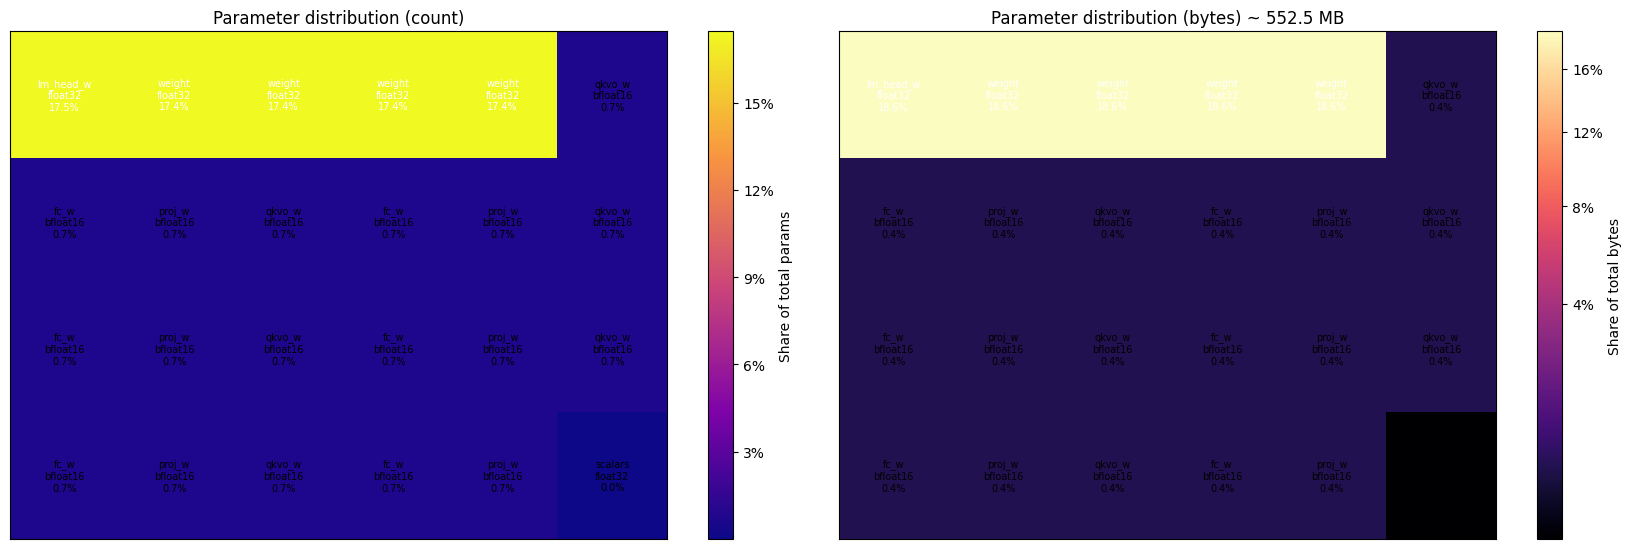

In [12]:
from matplotlib.colors import LinearSegmentedColormap

_colors = ["#0d0887", "#7e03a8", "#cc4678", "#f89441", "#f0f921"]
my_cmap = LinearSegmentedColormap.from_list("mycmap", _colors, N=256)

plot_param_heatmaps(model, cmap_count=my_cmap, cmap_bytes="magma")